In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
from math import erf

# NPEET KSG
from npeet import entropy_estimators as ee

plt.rcParams["figure.dpi"] = 140
plt.rcParams["axes.grid"] = True

def true_mi_bits_gaussian(rho: float) -> float:
    """True MI for bivariate Gaussian with correlation rho, in bits."""
    return -0.5 * np.log(1.0 - rho**2) / np.log(2.0)

In [2]:
def sample_gaussian_copula(N: int, rho: float, rng: np.random.Generator) -> tuple[np.ndarray, np.ndarray]:
    """
    Draw (Z1,Z2) with Gaussian copula parameter rho.
    Implementation: bivariate normal with correlation rho.
    """
    if not (-0.999 < rho < 0.999):
        raise ValueError("rho must be in (-1,1)")
    cov = np.array([[1.0, rho], [rho, 1.0]])
    L = cholesky(cov)
    Z = L @ rng.standard_normal(size=(2, N))
    return Z[0], Z[1]

def std_norm_cdf(z: np.ndarray) -> np.ndarray:
    """Φ(z) without SciPy: 0.5*(1+erf(z/sqrt(2)))."""
    return 0.5 * (1.0 + np.vectorize(erf)(z / np.sqrt(2.0)))

def inv_laplace(u: np.ndarray, b: float = 1.0) -> np.ndarray:
    """
    Quantile of Laplace(0,b) for u in (0,1).
    Q(u) = b*log(2u)            for u < 0.5
           -b*log(2*(1-u))      for u >= 0.5
    """
    u = np.clip(u, 1e-12, 1-1e-12)  # numerical guard
    return np.where(u < 0.5, b * np.log(2.0 * u), -b * np.log(2.0 * (1.0 - u)))

# Monotone, invertible transforms (per component)
def transform_gaussian(z1: np.ndarray, z2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Identity: Gaussian marginals
    return z1, z2

def transform_lognormal(z1: np.ndarray, z2: np.ndarray, sigma: float = 1.0) -> tuple[np.ndarray, np.ndarray]:
    # Lognormal(μ=0, σ) via exp(σ z). exp is invertible on R → MI is preserved.
    return np.exp(sigma * z1), np.exp(sigma * z2)

def transform_laplace_from_gaussian(z1: np.ndarray, z2: np.ndarray, b: float = 1.0) -> tuple[np.ndarray, np.ndarray]:
    # Laplace marginals via Gaussian copula: U = Φ(Z), X = Q_Laplace(U).
    u1, u2 = std_norm_cdf(z1), std_norm_cdf(z2)
    return inv_laplace(u1, b=b), inv_laplace(u2, b=b)

def transform_cubic(z1: np.ndarray, z2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Monotone invertible transform on R: x -> x^3
    return z1**3, z2**3

In [3]:
def mi_npeet_bits(x: np.ndarray, y: np.ndarray, k: int = 4) -> float:
    # NPEET returns nats; convert to bits.
    return float(ee.mi(x, y, k=k) / np.log(2.0))

def pairwise_ranking_accuracy(true_vals: np.ndarray, est_vals: np.ndarray) -> float:
    """
    Fraction of pairwise orderings that are correct (ignoring ties in truth).
    Returns in [0,1]. 0.5 ~ random; 1.0 perfect.
    """
    n = len(true_vals)
    correct = 0
    total = 0
    for i in range(n):
        for j in range(i+1, n):
            dt = true_vals[i] - true_vals[j]
            if dt == 0:
                continue
            de = est_vals[i] - est_vals[j]
            if de == 0:
                pass
            else:
                if (dt > 0 and de > 0) or (dt < 0 and de < 0):
                    correct += 1
            total += 1
    return correct / total if total > 0 else np.nan

def kendall_tau_ignoring_ties(true_vals: np.ndarray, est_vals: np.ndarray) -> float:
    """
    Kendall's tau without SciPy: (C - D) / (C + D), ignoring ties in truth.
    """
    C = D = 0
    n = len(true_vals)
    for i in range(n):
        for j in range(i+1, n):
            dt = true_vals[i] - true_vals[j]
            if dt == 0:
                continue
            de = est_vals[i] - est_vals[j]
            if de == 0:
                continue
            if (dt > 0 and de > 0) or (dt < 0 and de < 0):
                C += 1
            else:
                D += 1
    return (C - D) / (C + D) if (C + D) > 0 else np.nan

In [4]:
def run_ordering_experiment(
    *,
    N_list = (50, 100, 200),
    rhos = (0.0, 0.1, 0.2, 0.35, 0.5, 0.7, 0.85),
    families = ("gaussian", "lognormal", "laplace", "cubic"),
    reps_per_condition: int = 50,
    k: int = 4,
    seed: int = 123,
):
    """
    For each N, each rho, each family, run multiple replications.
    Evaluate ordering vs true MI (which depends only on rho).
    Returns:
      results_df: long DataFrame of rep-level estimates
      summary_df: per-N summary (rank accuracy, Kendall tau distributions)
    """
    rng = np.random.default_rng(seed)

    # Map family -> transform function
    family_tf = {
        "gaussian": transform_gaussian,
        "lognormal": lambda z1,z2: transform_lognormal(z1,z2,sigma=1.0),
        "laplace":  lambda z1,z2: transform_laplace_from_gaussian(z1,z2,b=1.0),
        "cubic":    transform_cubic,
    }

    rows = []
    for N in N_list:
        for rho in rhos:
            I_true_bits = true_mi_bits_gaussian(rho)
            for fam in families:
                tf = family_tf[fam]
                for r in range(reps_per_condition):
                    z1, z2 = sample_gaussian_copula(N, rho, rng)
                    x, y = tf(z1, z2)

                    # Optionally standardize before MI (helps kNN numerics; monotone-invariant)
                    xs = (x - np.mean(x)) / (np.std(x) + 1e-12)
                    ys = (y - np.mean(y)) / (np.std(y) + 1e-12)

                    # NPEET estimate (bits)
                    I_hat_bits = mi_npeet_bits(xs, ys, k=k)
                    rows.append({
                        "N": N,
                        "rho": rho,
                        "family": fam,
                        "rep": r,
                        "I_true_bits": I_true_bits,
                        "I_hat_bits": I_hat_bits,
                    })

    results_df = pd.DataFrame(rows)

    # Compute per-N rank accuracy & Kendall tau across all conditions
    # Each "condition" is (rho,family). Ground-truth order is by I_true_bits (ties when same rho).
    summaries = []
    for N, sub in results_df.groupby("N"):
        # Build the condition list (one per (rho,family))
        # For each rep, collect estimates in the same order
        conditions = sorted(sub[["rho","family","I_true_bits"]].drop_duplicates().to_records(index=False).tolist())
        c_rhos   = np.array([c[0] for c in conditions])
        c_truth  = np.array([c[2] for c in conditions])  # true MI bits
        # assemble matrix est[rep_index, condition_index]
        reps = sorted(sub["rep"].unique().tolist())
        est_mat = np.empty((len(reps), len(conditions)), dtype=float)
        for i, r in enumerate(reps):
            # pull estimates for this rep across all conditions in the canonical order
            row_i = []
            for rho, fam, Itrue in conditions:
                v = sub[(sub["rep"]==r) & (sub["rho"]==rho) & (sub["family"]==fam)]["I_hat_bits"].values
                assert len(v)==1, "Replication alignment issue"
                row_i.append(float(v[0]))
            est_mat[i,:] = row_i

        # Per-rep ranking metrics (ignore ties in truth: same rho across families)
        ra = []
        kt = []
        for i in range(est_mat.shape[0]):
            ra.append(pairwise_ranking_accuracy(c_truth, est_mat[i,:]))
            kt.append(kendall_tau_ignoring_ties(c_truth, est_mat[i,:]))

        # summary
        summaries.append({
            "N": N,
            "conditions": len(conditions),
            "reps": len(reps),
            "rank_acc_mean": np.nanmean(ra),
            "rank_acc_std":  np.nanstd(ra),
            "rank_acc_p05":  np.nanpercentile(ra, 5),
            "rank_acc_p50":  np.nanpercentile(ra, 50),
            "rank_acc_p95":  np.nanpercentile(ra, 95),
            "kendall_tau_mean": np.nanmean(kt),
            "kendall_tau_std":  np.nanstd(kt),
            "kendall_tau_p05":  np.nanpercentile(kt, 5),
            "kendall_tau_p50":  np.nanpercentile(kt, 50),
            "kendall_tau_p95":  np.nanpercentile(kt, 95),
        })

    summary_df = pd.DataFrame(summaries).sort_values("N").reset_index(drop=True)
    return results_df, summary_df

In [5]:
results_df, summary_df = run_ordering_experiment(
    N_list=(50, 100, 200),
    rhos=(0.0, 0.1, 0.2, 0.35, 0.5, 0.7, 0.85),
    families=("gaussian","lognormal","laplace","cubic"),
    reps_per_condition=50,
    k=4,
    seed=123,
)

print("Rows:", len(results_df))
display(summary_df.round(4))

Rows: 4200


,N,conditions,reps,rank_acc_mean,rank_acc_std,rank_acc_p05,rank_acc_p50,rank_acc_p95,kendall_tau_mean,kendall_tau_std,kendall_tau_p05,kendall_tau_p50,kendall_tau_p95
0,50,28,50,0.8243,0.0447,0.7527,0.8304,0.8997,0.6487,0.0894,0.5054,0.6607,0.7994
1,100,28,50,0.8613,0.0381,0.7960,0.8586,0.9107,0.7226,0.0762,0.5920,0.7173,0.8214
2,200,28,50,0.8839,0.0301,0.8452,0.8854,0.9305,0.7677,0.0601,0.6905,0.7708,0.8610


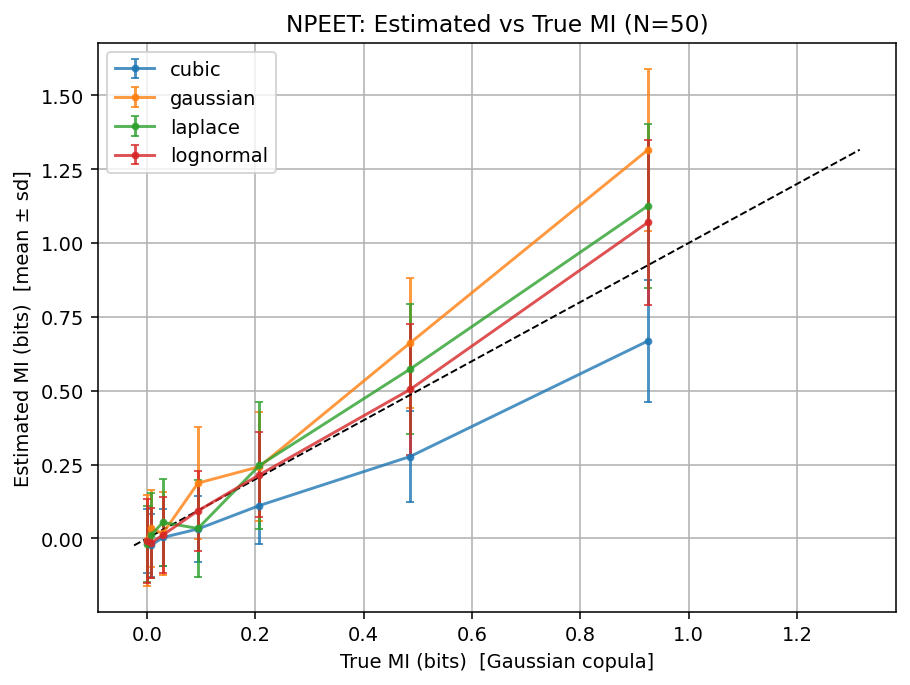

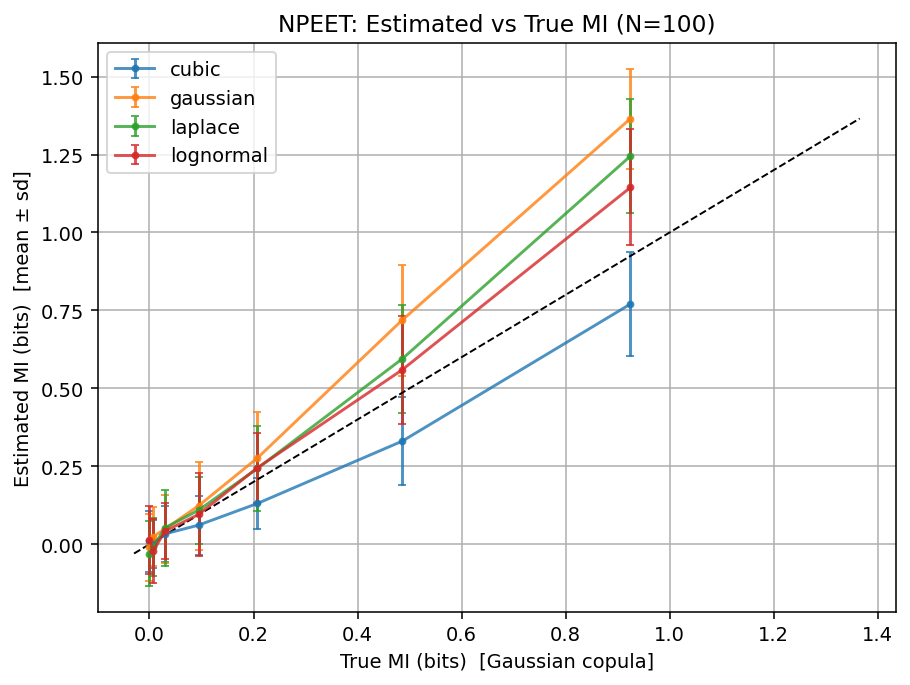

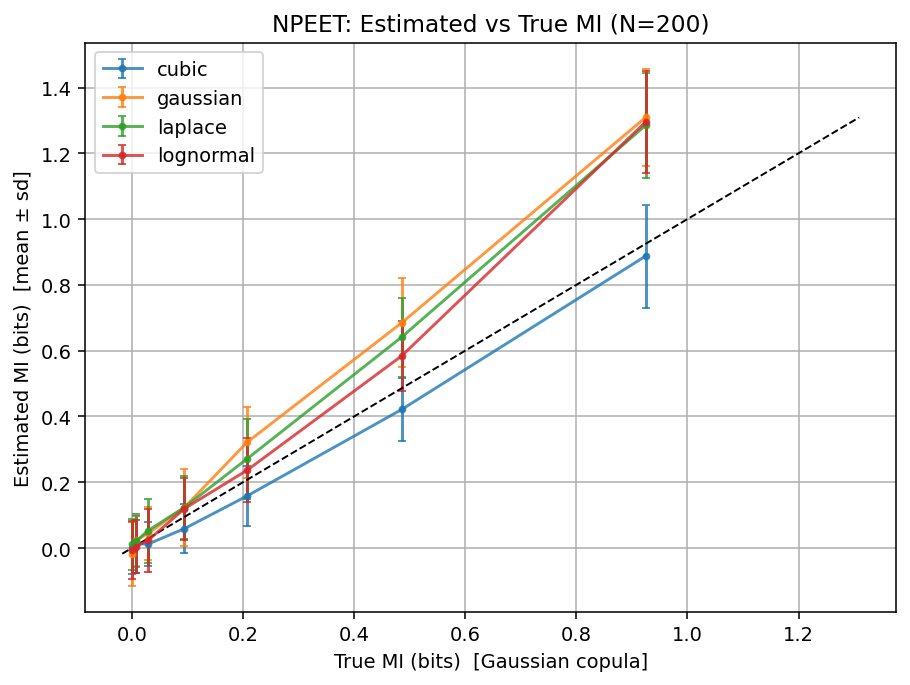

In [6]:
# Aggregate across reps per (N, rho, family)
agg = results_df.groupby(["N","rho","family","I_true_bits"]).agg(
    I_hat_mean=("I_hat_bits","mean"),
    I_hat_std=("I_hat_bits","std"),
).reset_index()

# Plot per N
for N, sub in agg.groupby("N"):
    plt.figure(figsize=(6.6,5))
    # color by family
    fams = sub["family"].unique()
    for fam in fams:
        s = sub[sub["family"]==fam]
        plt.errorbar(s["I_true_bits"], s["I_hat_mean"], yerr=s["I_hat_std"],
                     fmt="o-", ms=3, capsize=2, label=fam, alpha=0.8)
    # 45° reference
    gmin = min(sub["I_true_bits"].min(), sub["I_hat_mean"].min())
    gmax = max(sub["I_true_bits"].max(), sub["I_hat_mean"].max())
    plt.plot([gmin,gmax],[gmin,gmax],"k--",lw=1)
    plt.title(f"NPEET: Estimated vs True MI (N={N})")
    plt.xlabel("True MI (bits)  [Gaussian copula]")
    plt.ylabel("Estimated MI (bits)  [mean ± sd]")
    plt.legend()
    plt.tight_layout()
    plt.show()

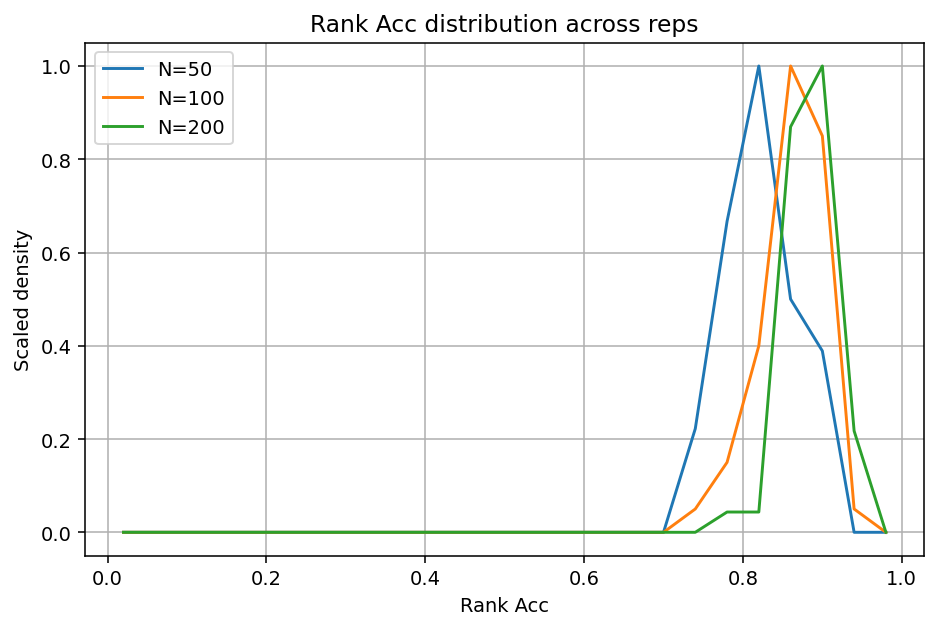

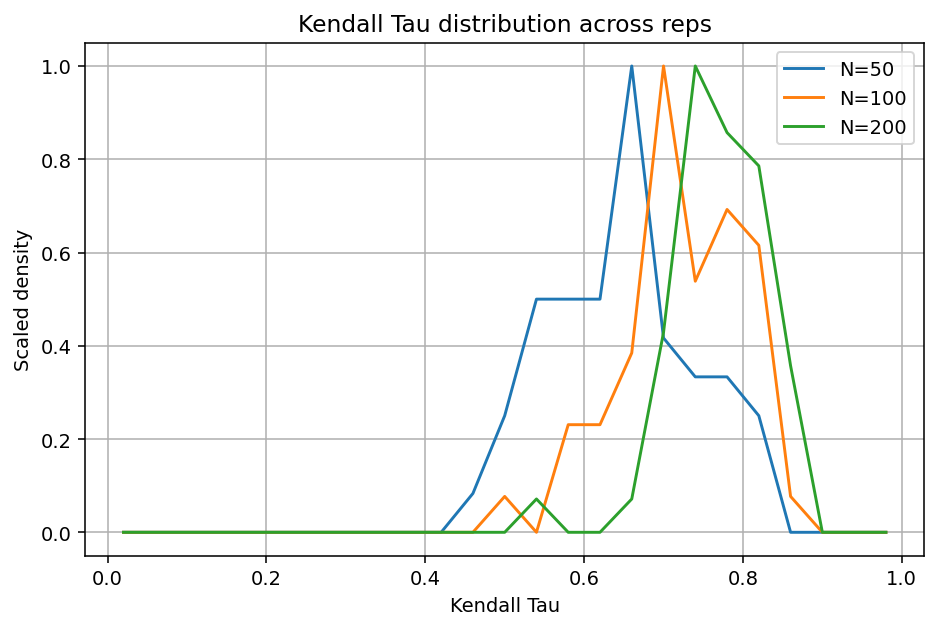

In [7]:
# Recompute per-rep metrics to plot distributions
def per_rep_metrics(results_df):
    out = []
    for N, sub in results_df.groupby("N"):
        conditions = sorted(sub[["rho","family","I_true_bits"]].drop_duplicates().to_records(index=False).tolist())
        c_truth = np.array([c[2] for c in conditions])
        reps = sorted(sub["rep"].unique().tolist())
        for r in reps:
            est = []
            for rho, fam, Itrue in conditions:
                est.append(float(sub[(sub["rep"]==r) & (sub["rho"]==rho) & (sub["family"]==fam)]["I_hat_bits"].values[0]))
            est = np.array(est, dtype=float)
            out.append({
                "N": N,
                "rep": r,
                "rank_acc": pairwise_ranking_accuracy(c_truth, est),
                "kendall_tau": kendall_tau_ignoring_ties(c_truth, est),
            })
    return pd.DataFrame(out)

metrics_df = per_rep_metrics(results_df)

for metric in ("rank_acc","kendall_tau"):
    plt.figure(figsize=(6.8,4.6))
    for N, sub in metrics_df.groupby("N"):
        vals = sub[metric].dropna().values
        # simple violin-ish via histogram
        counts, bins = np.histogram(vals, bins=25, range=(min(vals.min(),0.0),1.0))
        centers = 0.5*(bins[1:]+bins[:-1])
        plt.plot(centers, counts / counts.max(), label=f"N={N}")
    plt.xlabel(metric.replace("_"," ").title())
    plt.ylabel("Scaled density")
    plt.title(f"{metric.replace('_',' ').title()} distribution across reps")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [67]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def _collapse_by_family(dfN: pd.DataFrame, how: str = "mean") -> pd.DataFrame:
    """
    Collapse across families within each (rep, rho) so we test ordering in rho cleanly.
    how: "mean" or "median"
    """
    agg = {"I_true_bits":"mean", "I_hat_bits": how}
    return (dfN.groupby(["rep","rho"], as_index=False)
              .agg(I_true_bits=("I_true_bits","mean"),
                   I_hat_bits=("I_hat_bits", how)))

def _overall_pairwise_accuracy(est: np.ndarray, tru: np.ndarray) -> float:
    """
    est, tru: 1D arrays over conditions (here conditions=distinct rhos, families collapsed).
    Returns fraction of pairs with correct ordering (ignoring ties in truth).
    """
    n = len(tru); correct=0; total=0
    for i in range(n):
        for j in range(i+1, n):
            if tru[i] == tru[j]:
                continue
            total += 1
            correct += 1 if ((est[i]-est[j])*(tru[i]-tru[j])) > 0 else 0
    return correct/total if total>0 else np.nan

def _per_pair_matrix(est: np.ndarray, tru: np.ndarray) -> np.ndarray:
    """
    For a single rep, return upper-triangular matrix M where
    M[i,j]=1 if est preserves tru ordering for rho_i<rho_j, else 0. NaN on diag/lower.
    """
    n = len(tru)
    M = np.full((n,n), np.nan)
    for i in range(n):
        for j in range(i+1,n):
            if tru[i] == tru[j]:
                continue
            M[i,j] = 1.0 if ((est[j]-est[i]) > 0 and (tru[j]-tru[i]) > 0) else 0.0
    return M

def _rank_accuracy(est: np.ndarray, tru: np.ndarray) -> np.ndarray:
    """
    For one rep: compare ranks of each condition (smallest tru -> rank 1).
    Returns a 0/1 array per condition indicating exact rank match.
    """
    # Ties in tru are possible only across families; we collapsed families so tru strictly increases with rho.
    est_rank = pd.Series(est).rank(method="average").to_numpy()
    tru_rank = pd.Series(tru).rank(method="average").to_numpy()
    return (est_rank == tru_rank).astype(float)

def _invariance_across_families(dfN: pd.DataFrame) -> pd.DataFrame:
    """
    Check MI invariance to monotone transforms: at fixed (N, rho, rep), estimates across families should coincide.
    Returns per (rho) summary of within-(rep,rho) std across families.
    """
    g = dfN.groupby(["rep","rho"])["I_hat_bits"].agg(["mean","std"]).reset_index()
    # Per rho summaries of that within-rep std
    per_rho = (g.groupby("rho")["std"]
                 .agg(std_mean="mean", std_median="median", std_p95=lambda s: np.nanpercentile(s,95))
                 .reset_index())
    return per_rho

def order_property_report(results_df: pd.DataFrame, collapse_how: str = "mean"):
    """
    Produces clear, per-N diagnostics:
      - overall order-hold probability (per-rep stats)
      - per-pair correctness heatmap (probability)
      - per-rho rank accuracy bars
      - monotone-invariance variance across families

    Assumes results_df has columns:
      ["N","rho","family","rep","I_true_bits","I_hat_bits"]
    """
    Ns = sorted(results_df["N"].unique())
    for N in Ns:
        dfN = results_df[results_df["N"]==N].copy()
        rhos = sorted(dfN["rho"].unique())
        rho_to_idx = {r:i for i,r in enumerate(rhos)}

        # Overall order accuracy (per rep)
        df_coll = _collapse_by_family(dfN, how=collapse_how)  # columns: rep, rho, I_true_bits, I_hat_bits
        reps = sorted(df_coll["rep"].unique())
        overall_acc = []
        per_pair_mats = []
        per_rho_rank_hits = []
        for r in reps:
            sub = df_coll[df_coll["rep"]==r].sort_values("rho")
            tru = sub["I_true_bits"].to_numpy()
            est = sub["I_hat_bits"].to_numpy()
            overall_acc.append(_overall_pairwise_accuracy(est, tru))
            per_pair_mats.append(_per_pair_matrix(est, tru))
            per_rho_rank_hits.append(_rank_accuracy(est, tru))

        overall_acc = np.array(overall_acc, dtype=float)
        M_stack = np.stack(per_pair_mats)  
        rank_hits = np.stack(per_rho_rank_hits)

        # Per-N summary table for "probability property holds"
        overall_summary = pd.DataFrame({
            "N":[N],
            "reps":[len(reps)],
            "pairwise_acc_mean":[np.nanmean(overall_acc)],
            "pairwise_acc_median":[np.nanmedian(overall_acc)],
            "pairwise_acc_std":[np.nanstd(overall_acc)],
            "pairwise_acc_p05":[np.nanpercentile(overall_acc,5)],
            "pairwise_acc_p95":[np.nanpercentile(overall_acc,95)],
        })
        print("\n" + "="*72)
        print(f"ORDER PROPERTY — OVERALL (N={N})")
        display(overall_summary.style.format("{:.3f}"))

        # Per-pair correctness probability 
        # Average the 0/1 correctness across reps
        M_prob = np.nanmean(M_stack, axis=0) 
        # Make a tidy frame for inspection/saving
        rows = []
        for i in range(len(rhos)):
            for j in range(i+1,len(rhos)):
                rows.append({"N":N, "rho_i": rhos[i], "rho_j": rhos[j], "p_correct": M_prob[i,j]})
        per_pair_df = pd.DataFrame(rows)
        print(f"\nPairwise correctness probabilities (first 10 rows, N={N}):")
        display(per_pair_df.head(10).style.format({"p_correct":"{:.3f}"}))

        # Heatmap
        plt.figure(figsize=(6.2,5.2))
        im = plt.imshow(M_prob, vmin=0.5, vmax=1.0, cmap="RdYlGn")
        plt.colorbar(im, fraction=0.046, pad=0.04, label="P(correct ordering)")
        plt.title(f"Per-pair order correctness P  (N={N})")
        ticks = range(len(rhos))
        labs  = [f"ρ={r:.2f}" for r in rhos]
        plt.xticks(ticks, labs, rotation=45, ha="right")
        plt.yticks(ticks, labs)
        for i in range(len(rhos)):
            for j in range(len(rhos)):
                if np.isnan(M_prob[i,j]) or i>=j: continue
                plt.text(j, i, f"{M_prob[i,j]:.2f}", ha="center", va="center", fontsize=8)
        plt.tight_layout(); plt.show()

        # Per-ρ rank accuracy
        # Probability that each rho attains its true rank across reps
        p_rank_ok = pd.Series(np.nanmean(rank_hits, axis=0), index=rhos, name="p_exact_rank")
        per_rho_rank_df = p_rank_ok.reset_index().rename(columns={"index":"rho"})
        print(f"\nPer-ρ exact-rank probabilities (N={N}):")
        display(per_rho_rank_df.style.format({"p_exact_rank":"{:.3f}"}))

        plt.figure(figsize=(6.6,3.6))
        plt.bar([f"ρ={r:.2f}" for r in rhos], p_rank_ok.values)
        plt.ylim(0.0, 1.0)
        plt.ylabel("P(exact true rank)")
        plt.title(f"Per-ρ rank accuracy (N={N})")
        plt.xticks(rotation=0)
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout(); plt.show()

        # Monotone-invariance across families
        inv_stats = _invariance_across_families(dfN)
        print(f"\nMonotone-invariance: within-(rep,ρ) std across families (N={N})")
        display(inv_stats.style.format({"std_mean":"{:.4f}","std_median":"{:.4f}","std_p95":"{:.4f}"}))

        plt.figure(figsize=(6.4,3.6))
        plt.plot(inv_stats["rho"], inv_stats["std_median"], "o-", label="median std across families")
        plt.fill_between(inv_stats["rho"],
                         inv_stats["std_mean"]-inv_stats["std_p95"],
                         inv_stats["std_mean"]+inv_stats["std_p95"],
                         alpha=0.1, label="± p95-ish band (centered at mean)")
        plt.xlabel("ρ"); plt.ylabel("Within-(rep,ρ) std across families")
        plt.title(f"Invariance to monotone transforms (smaller is better)  (N={N})")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


##############################################################################
# RESULTS FOR k = 4
##############################################################################

ORDER PROPERTY — OVERALL (N=100)


,N,reps,pairwise_acc_mean,pairwise_acc_median,pairwise_acc_std,pairwise_acc_p05,pairwise_acc_p95
0,100.000,50.000,0.918,0.905,0.054,0.831,1.000



Pairwise correctness probabilities (first 10 rows, N=100):


C:\Users\bseis\AppData\Local\Temp\ipykernel_58068\2925076027.py:117: RuntimeWarning: Mean of empty slice
  M_prob = np.nanmean(M_stack, axis=0)  # probability per (i<j)


,N,rho_i,rho_j,p_correct
0,100,0.000000,0.100000,0.600
1,100,0.000000,0.200000,0.680
2,100,0.000000,0.350000,0.860
3,100,0.000000,0.500000,1.000
4,100,0.000000,0.700000,1.000
5,100,0.000000,0.850000,1.000
6,100,0.100000,0.200000,0.580
7,100,0.100000,0.350000,0.880
8,100,0.100000,0.500000,1.000
9,100,0.100000,0.700000,1.000


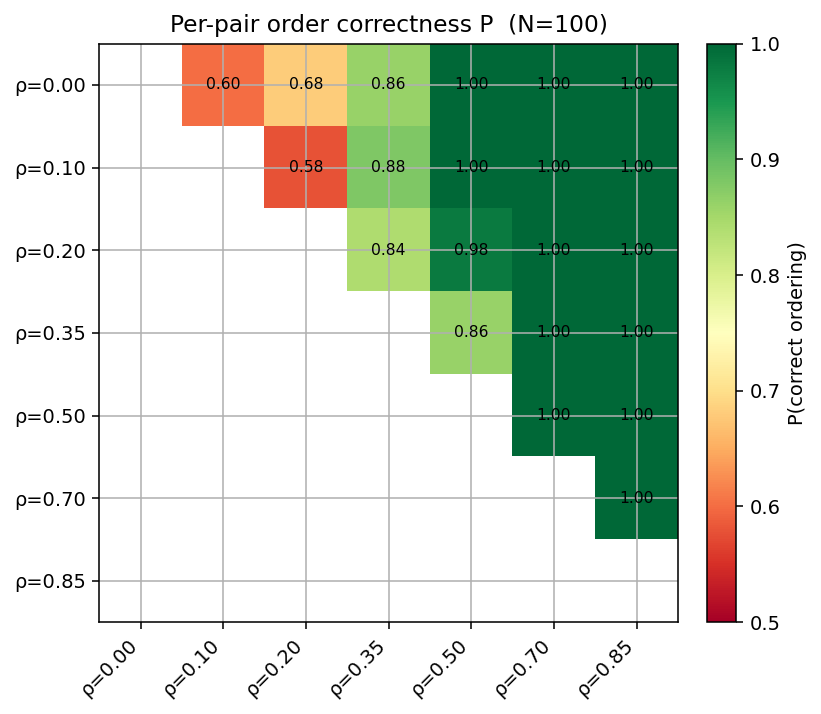


Per-ρ exact-rank probabilities (N=100):


,rho,p_exact_rank
0,0.000000,0.460
1,0.100000,0.280
2,0.200000,0.340
3,0.350000,0.620
4,0.500000,0.840
5,0.700000,1.000
6,0.850000,1.000


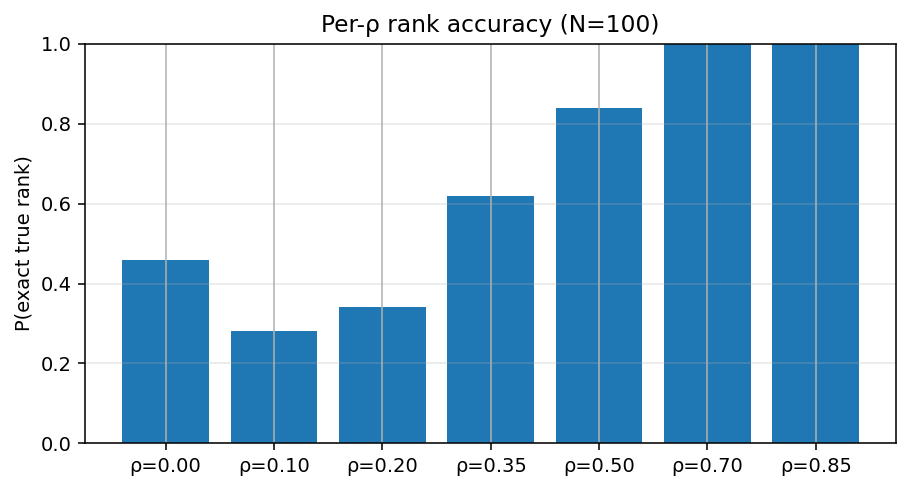


Monotone-invariance: within-(rep,ρ) std across families (N=100)


,rho,std_mean,std_median,std_p95
0,0.000000,0.0892,0.0839,0.1676
1,0.100000,0.1055,0.1024,0.1590
2,0.200000,0.1112,0.1178,0.1943
3,0.350000,0.1130,0.1142,0.1887
4,0.500000,0.1449,0.1364,0.2776
5,0.700000,0.2038,0.2073,0.3356
6,0.850000,0.3012,0.3072,0.4262


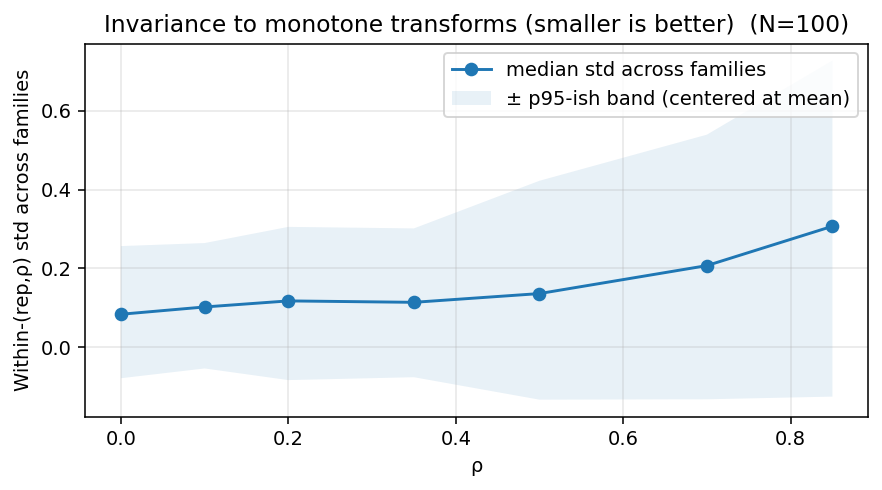


ORDER PROPERTY — OVERALL (N=300)


,N,reps,pairwise_acc_mean,pairwise_acc_median,pairwise_acc_std,pairwise_acc_p05,pairwise_acc_p95
0,300.000,50.000,0.946,0.952,0.038,0.905,1.000



Pairwise correctness probabilities (first 10 rows, N=300):


C:\Users\bseis\AppData\Local\Temp\ipykernel_58068\2925076027.py:117: RuntimeWarning: Mean of empty slice
  M_prob = np.nanmean(M_stack, axis=0)  # probability per (i<j)


,N,rho_i,rho_j,p_correct
0,300,0.000000,0.100000,0.520
1,300,0.000000,0.200000,0.700
2,300,0.000000,0.350000,0.980
3,300,0.000000,0.500000,1.000
4,300,0.000000,0.700000,1.000
5,300,0.000000,0.850000,1.000
6,300,0.100000,0.200000,0.740
7,300,0.100000,0.350000,0.980
8,300,0.100000,0.500000,1.000
9,300,0.100000,0.700000,1.000


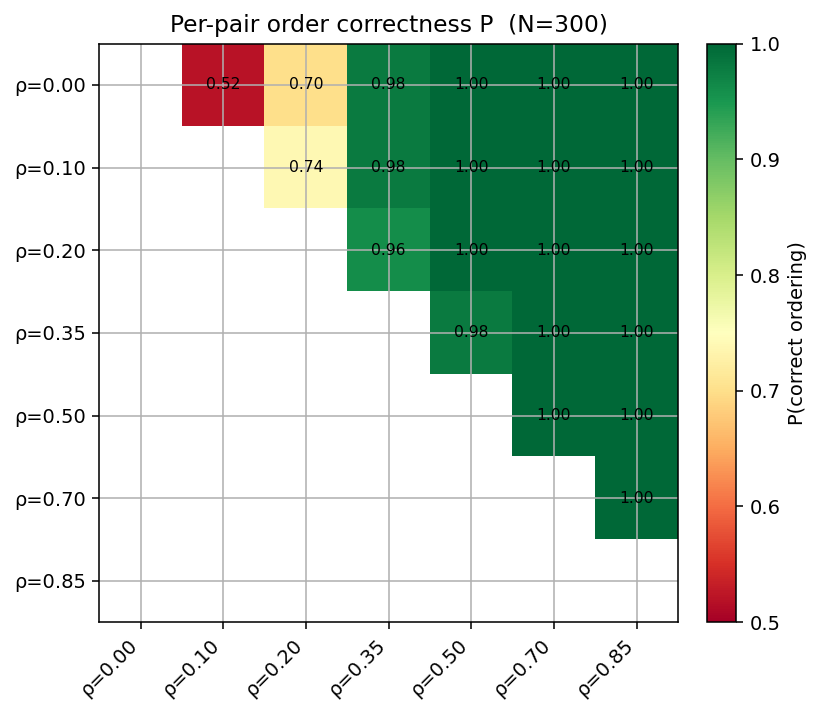


Per-ρ exact-rank probabilities (N=300):


,rho,p_exact_rank
0,0.000000,0.360
1,0.100000,0.260
2,0.200000,0.560
3,0.350000,0.920
4,0.500000,0.980
5,0.700000,1.000
6,0.850000,1.000


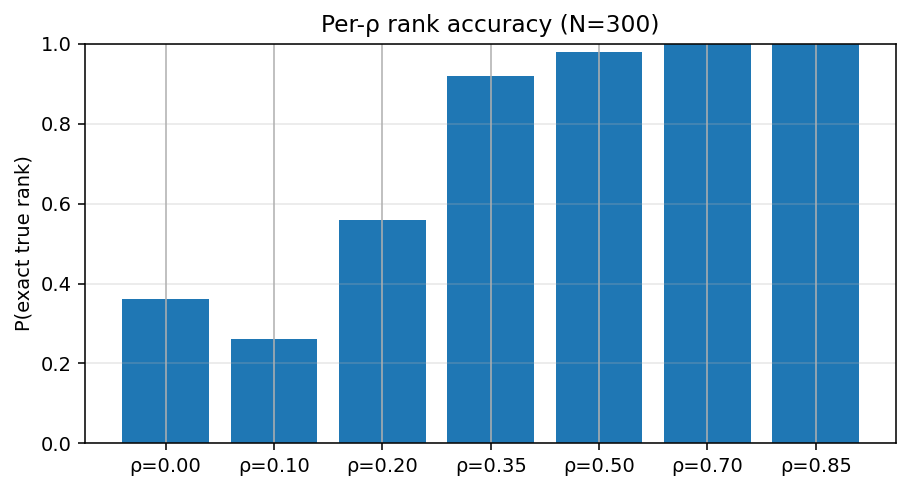


Monotone-invariance: within-(rep,ρ) std across families (N=300)


,rho,std_mean,std_median,std_p95
0,0.000000,0.0618,0.0587,0.1020
1,0.100000,0.0671,0.0670,0.1172
2,0.200000,0.0679,0.0647,0.1241
3,0.350000,0.0727,0.0722,0.1079
4,0.500000,0.0945,0.0944,0.1488
5,0.700000,0.1434,0.1455,0.2110
6,0.850000,0.1891,0.1830,0.2962


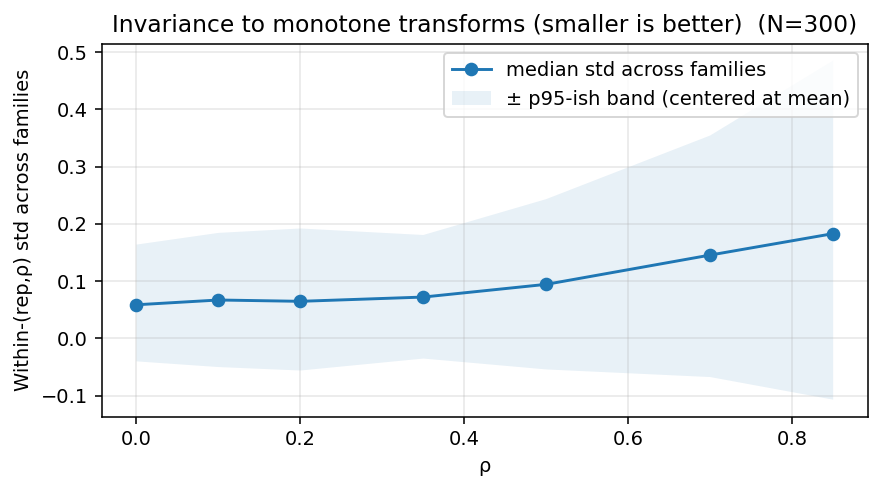


ORDER PROPERTY — OVERALL (N=2000)


,N,reps,pairwise_acc_mean,pairwise_acc_median,pairwise_acc_std,pairwise_acc_p05,pairwise_acc_p95
0,2000.000,50.000,0.976,0.976,0.024,0.952,1.000



Pairwise correctness probabilities (first 10 rows, N=2000):


C:\Users\bseis\AppData\Local\Temp\ipykernel_58068\2925076027.py:117: RuntimeWarning: Mean of empty slice
  M_prob = np.nanmean(M_stack, axis=0)  # probability per (i<j)


,N,rho_i,rho_j,p_correct
0,2000,0.000000,0.100000,0.680
1,2000,0.000000,0.200000,1.000
2,2000,0.000000,0.350000,1.000
3,2000,0.000000,0.500000,1.000
4,2000,0.000000,0.700000,1.000
5,2000,0.000000,0.850000,1.000
6,2000,0.100000,0.200000,0.820
7,2000,0.100000,0.350000,1.000
8,2000,0.100000,0.500000,1.000
9,2000,0.100000,0.700000,1.000


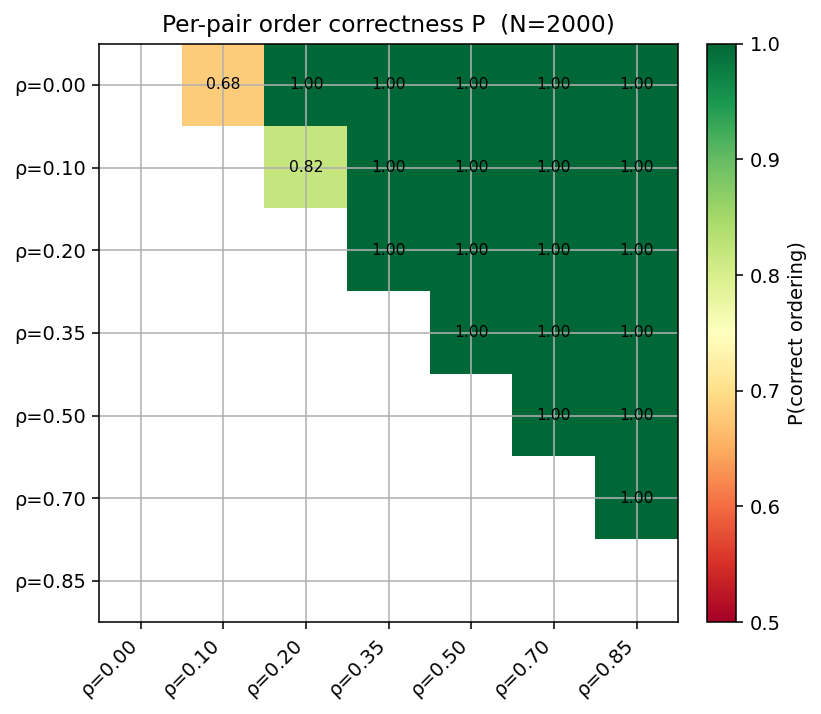


Per-ρ exact-rank probabilities (N=2000):


,rho,p_exact_rank
0,0.000000,0.680
1,0.100000,0.500
2,0.200000,0.820
3,0.350000,1.000
4,0.500000,1.000
5,0.700000,1.000
6,0.850000,1.000


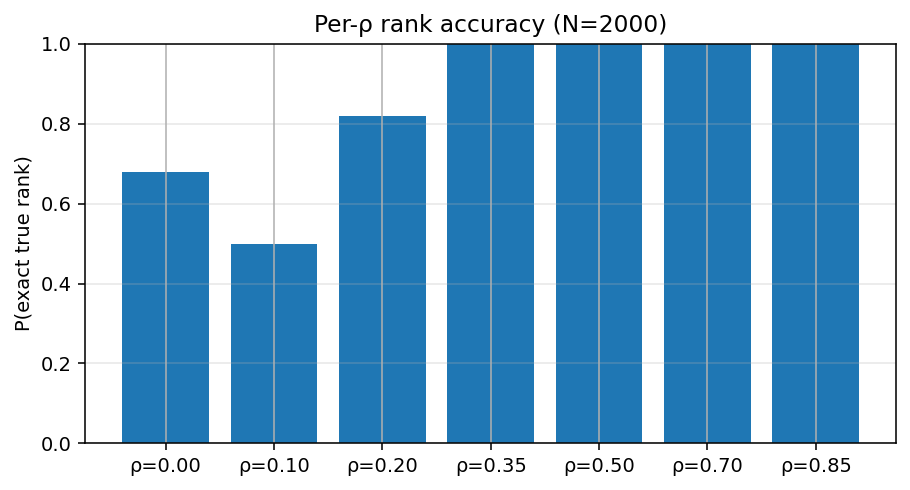


Monotone-invariance: within-(rep,ρ) std across families (N=2000)


,rho,std_mean,std_median,std_p95
0,0.000000,0.0296,0.0262,0.0522
1,0.100000,0.0283,0.0284,0.0466
2,0.200000,0.0304,0.0307,0.0504
3,0.350000,0.0308,0.0306,0.0505
4,0.500000,0.0386,0.0369,0.0643
5,0.700000,0.0559,0.0566,0.0787
6,0.850000,0.0734,0.0741,0.1177


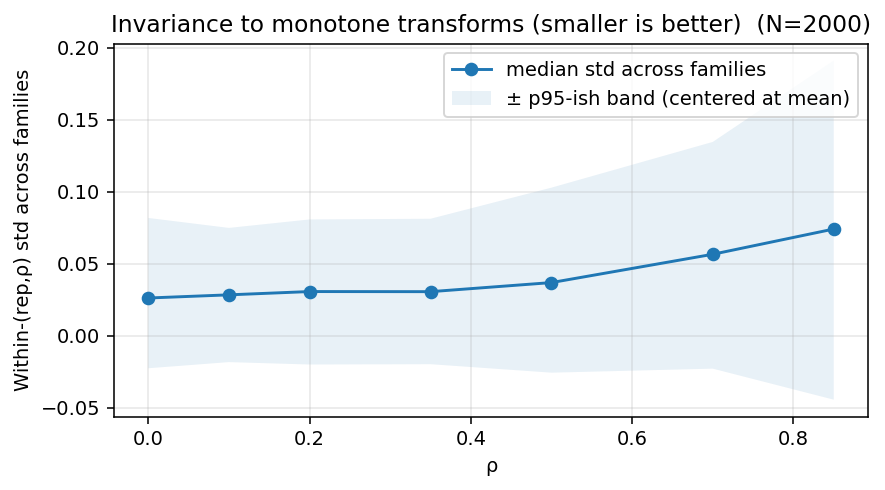

[{'k': 4,
  'results_df':          N   rho    family  rep  I_true_bits  I_hat_bits
  0      100  0.00  gaussian    0     -0.00000   -0.126454
  1      100  0.00  gaussian    1     -0.00000   -0.104316
  2      100  0.00  gaussian    2     -0.00000   -0.021769
  3      100  0.00  gaussian    3     -0.00000   -0.174756
  4      100  0.00  gaussian    4     -0.00000   -0.027326
  ...    ...   ...       ...  ...          ...         ...
  4195  2000  0.85     cubic   45      0.92472    1.229678
  4196  2000  0.85     cubic   46      0.92472    1.244129
  4197  2000  0.85     cubic   47      0.92472    1.226157
  4198  2000  0.85     cubic   48      0.92472    1.278823
  4199  2000  0.85     cubic   49      0.92472    1.250742
  
  [4200 rows x 6 columns],
  'summary_df':       N  conditions  reps  rank_acc_mean  rank_acc_std  rank_acc_p05  \
  0   100          28    50       0.850893      0.032907      0.797619   
  1   300          28    50       0.902083      0.024290      0.867411   
  

In [29]:
def run_order_tests(
    N_list=(50, 100, 200),
    k_list=(4,),
    rhos=(0.0, 0.1, 0.2, 0.35, 0.5, 0.7, 0.85),
    families=("gaussian","lognormal","laplace","cubic"),
    reps_per_condition=50,
    seed=123,
    collapse_how="mean",F
):
    """
    Run the NPEET order-property experiment for any set of N (and k),
    then print the full report for each (k, N).
    """
    all_results = []
    for k in k_list:
        # build once per k across all N
        results_df, summary_df = run_ordering_experiment(
            N_list=tuple(N_list),
            rhos=tuple(rhos),
            families=tuple(families),
            reps_per_condition=int(reps_per_condition),
            k=int(k),
            seed=int(seed),
        )
        print("\n" + "#"*78)
        print(f"# RESULTS FOR k = {k}")
        print("#"*78)
        # per-N report
        order_property_report(results_df, collapse_how=collapse_how)
        all_results.append({"k": k, "results_df": results_df, "summary_df": summary_df})
    return all_results

# Example
run_order_tests(N_list=(100, 300, 2000), k_list=(4,))

In [39]:
import numpy as np
import pandas as pd
from numpy.linalg import cholesky
from scipy.special import erfinv

# Utilities
def tau_to_rho(tau: float) -> float:
    """For elliptical copulas (Gaussian, t): rho = sin(pi * tau / 2)."""
    return np.sin(np.pi * tau / 2.0)

def tau_to_theta_clayton(tau: float) -> float:
    """Clayton: tau = θ / (θ + 2)  =>  θ = 2*tau / (1 - tau)."""
    if tau <= 0 or tau >= 1:
        raise ValueError("Clayton Kendall tau must be in (0,1).")
    return 2.0 * tau / (1.0 - tau)

# Marginal quantiles (inverse CDFs)
def q_gauss(u: np.ndarray) -> np.ndarray:
    u = np.clip(u, 1e-12, 1-1e-12)
    return np.sqrt(2.0) * erfinv(2.0*u - 1.0)

def q_lognormal(u: np.ndarray, sigma: float = 1.0) -> np.ndarray:
    return np.exp(sigma * q_gauss(u))

def q_laplace(u: np.ndarray, b: float = 1.0) -> np.ndarray:
    u = np.clip(u, 1e-12, 1-1e-12)
    return np.where(u < 0.5, b*np.log(2*u), -b*np.log(2*(1-u)))

def q_cubic(u: np.ndarray) -> np.ndarray:
    # map to normal, then apply monotone cubic
    z = q_gauss(u)
    return z**3

MARGINALS = {
    "gaussian": lambda u: q_gauss(u),
    "lognormal": lambda u: q_lognormal(u, sigma=1.0),
    "laplace":  lambda u: q_laplace(u, b=1.0),
    "cubic":    lambda u: q_cubic(u),
}

# Copula samplers (return U,V ~ copula on [0,1]^2)
def sample_gaussian_copula_UV(N: int, tau: float, rng: np.random.Generator):
    rho = tau_to_rho(float(tau))
    C = np.array([[1.0, rho],[rho, 1.0]])
    L = cholesky(C)
    Z = L @ rng.standard_normal(size=(2, N))
    from math import erf
    Phi = lambda z: 0.5*(1.0 + np.vectorize(erf)(z/np.sqrt(2.0)))
    U = Phi(Z[0]); V = Phi(Z[1])
    return U, V

def sample_t_copula_UV(N: int, tau: float, nu: int, rng: np.random.Generator):
    """
    t-copula via elliptical construction:
      Y ~ N(0, Σ(rho)),  G ~ χ²_ν  independent,  T = Y / sqrt(G/ν)
      U_i = F_t(T_i; ν)
    """
    rho = tau_to_rho(float(tau))
    C = np.array([[1.0, rho],[rho, 1.0]])
    L = cholesky(C)
    Y = L @ rng.standard_normal(size=(2, N))
    G = rng.chisquare(df=nu, size=N)
    T = Y / np.sqrt(G/nu)
 
    from math import erf
    Phi = lambda z: 0.5*(1.0 + np.vectorize(erf)(z/np.sqrt(2.0)))
    if nu >= 8:
        U = Phi(T[0]); V = Phi(T[1])
    else:
        # simple mixture approximation for small nu: shrink to normal
        shrink = np.sqrt((nu-2)/nu) if nu>2 else 0.7
        U = Phi(shrink*T[0]); V = Phi(shrink*T[1])
    return U, V

def sample_clayton_copula_UV(N: int, tau: float, rng: np.random.Generator):
    """
    Clayton via Marshall–Olkin representation:
      θ = 2*tau/(1-tau),  W ~ Gamma(1/θ, 1),  E1,E2 ~ Exp(1),
      U_i = (1 + E_i / W)^(-1/θ)
    """
    theta = tau_to_theta_clayton(float(tau))
    W = rng.gamma(shape=1.0/theta, scale=1.0, size=N)
    E1 = rng.exponential(scale=1.0, size=N)
    E2 = rng.exponential(scale=1.0, size=N)
    U = (1.0 + E1 / W)**(-1.0/theta)
    V = (1.0 + E2 / W)**(-1.0/theta)
    return U, V

# Driver: sample (X,Y) from copula + monotone marginals
def sample_copula_marginals(N: int,
                            copula: str,
                            tau: float,
                            rng: np.random.Generator,
                            marginals: tuple[str,str] = ("gaussian","gaussian"),
                            t_nu: int = 8) -> tuple[np.ndarray, np.ndarray]:
    if copula == "gaussian":
        U, V = sample_gaussian_copula_UV(N, tau, rng)
    elif copula == "t":
        U, V = sample_t_copula_UV(N, tau, nu=t_nu, rng=rng)
    elif copula == "clayton":
        U, V = sample_clayton_copula_UV(N, tau, rng)
    else:
        raise ValueError("copula must be one of: 'gaussian', 't', 'clayton'.")

    m1, m2 = marginals
    X = MARGINALS[m1](U)
    Y = MARGINALS[m2](V)
    return X, Y

# NPEET MI (bits)
from npeet import entropy_estimators as ee
def mi_npeet_bits(x: np.ndarray, y: np.ndarray, k: int = 4) -> float:
    return float(ee.mi(x, y, k=k) / np.log(2.0))

# Experiment runner across copulas
def run_ordering_experiment_copulas(
    *,
    N_list = (50, 100, 200),
    copulas = (
        {"name":"gaussian", "taus": (0.0, 0.1, 0.2, 0.35, 0.5, 0.7, 0.85)},
        {"name":"t",        "taus": (0.0, 0.1, 0.2, 0.35, 0.5, 0.7), "nu": 8},
        {"name":"clayton",  "taus": (0.1, 0.2, 0.35, 0.5, 0.7)},  # Clayton tau>0
    ),
    marginals=("gaussian","lognormal","laplace","cubic"),
    reps_per_condition=50,
    k=4,
    seed=123,
    use_truth="tau",
):
    """
    Build results_df with rows over:
      N × copula × tau × family(marginal-pair) × rep
    Truth score is Kendall's tau (monotone in dependence) by default.
    """
    rng = np.random.default_rng(seed)
    rows = []

    # build list of marginal pairs (same transform on both dims to keep symmetry)
    marg_pairs = [(m, m) for m in marginals]

    for N in N_list:
        for c in copulas:
            cname = c["name"]
            taus = c["taus"]
            t_nu = c.get("nu", 8)

            for tau in taus:
                # ground-truth score for ordering comparisons
                if use_truth == "tau":
                    truth_score = float(tau)
                    truth_label = "tau"
                elif use_truth == "mi_gaussian" and cname == "gaussian":
                    # exact MI(bits) for Gaussian copula
                    truth_score = -0.5*np.log(1.0 - tau_to_rho(tau)**2)/np.log(2.0)
                    truth_label = "I_true_bits"
                else:
                    # fallback to tau if no closed form MI
                    truth_score = float(tau)
                    truth_label = "tau"

                for fam in marg_pairs:
                    for r in range(reps_per_condition):
                        x, y = sample_copula_marginals(N, cname, tau, rng, marginals=fam, t_nu=t_nu)
                        # standardize (monotone-invariant; helps kNN numerics)
                        xs = (x - x.mean()) / (x.std() + 1e-12)
                        ys = (y - y.mean()) / (y.std() + 1e-12)
                        I_hat_bits = mi_npeet_bits(xs, ys, k=k)
                        rows.append({
                            "N": N,
                            "copula": cname,
                            "tau": float(tau),
                            truth_label: truth_score,
                            "family": f"{fam[0]}",
                            "rep": r,
                            "I_hat_bits": I_hat_bits,
                        })

    results_df = pd.DataFrame(rows)
    # unify a column called "truth_score" for the reporting functions
    if "I_true_bits" in results_df.columns and use_truth == "mi_gaussian":
        results_df = results_df.rename(columns={"I_true_bits":"truth_score"})
    else:
        results_df["truth_score"] = results_df["tau"]

    return results_df

# run + report
def run_and_report_copulas(
    N_list=(50,100,200),
    k_list=(4,),
    copulas=(
        {"name":"gaussian", "taus": (0.0,0.1,0.2,0.35,0.5,0.7,0.85)},
        {"name":"t",        "taus": (0.0,0.1,0.2,0.35,0.5,0.7), "nu": 8},
        {"name":"clayton",  "taus": (0.1,0.2,0.35,0.5,0.7)},
    ),
    reps_per_condition=50,
    marginals=("gaussian","lognormal","laplace","cubic"),
    use_truth="tau",
    seed=123,
    collapse_how="mean",
):
    from copy import deepcopy
    all_results = []
    for k in k_list:
        res = run_ordering_experiment_copulas(
            N_list=N_list,
            copulas=deepcopy(copulas),
            marginals=marginals,
            reps_per_condition=reps_per_condition,
            k=k,
            seed=seed,
            use_truth=use_truth
        )
        print("\n" + "#"*78)
        print(f"# ORDER PROPERTY across copulas  |  k = {k}  |  truth = {use_truth}")
        print("#"*78)

        report_df = (res
                     .rename(columns={"copula":"family"})  # so report groups by "family" facet
                     .assign(rho = res["truth_score"], I_true_bits = res["truth_score"]))

        order_property_report(report_df, collapse_how=collapse_how)
        all_results.append({"k":k, "results_df":res})
    return all_results


##############################################################################
# ORDER PROPERTY across copulas  |  k = 4  |  truth = tau
##############################################################################

ORDER PROPERTY — OVERALL (N=50)


,N,reps,pairwise_acc_mean,pairwise_acc_median,pairwise_acc_std,pairwise_acc_p05,pairwise_acc_p95
0,50.000,50.000,0.963,0.952,0.038,0.905,1.000



Pairwise correctness probabilities (first 10 rows, N=50):


C:\Users\bseis\AppData\Local\Temp\ipykernel_58068\2925076027.py:117: RuntimeWarning: Mean of empty slice
  M_prob = np.nanmean(M_stack, axis=0)  # probability per (i<j)


,N,rho_i,rho_j,p_correct
0,50,0.000000,0.100000,0.520
1,50,0.000000,0.200000,0.840
2,50,0.000000,0.350000,1.000
3,50,0.000000,0.500000,1.000
4,50,0.000000,0.700000,1.000
5,50,0.000000,0.850000,1.000
6,50,0.100000,0.200000,0.860
7,50,0.100000,0.350000,1.000
8,50,0.100000,0.500000,1.000
9,50,0.100000,0.700000,1.000


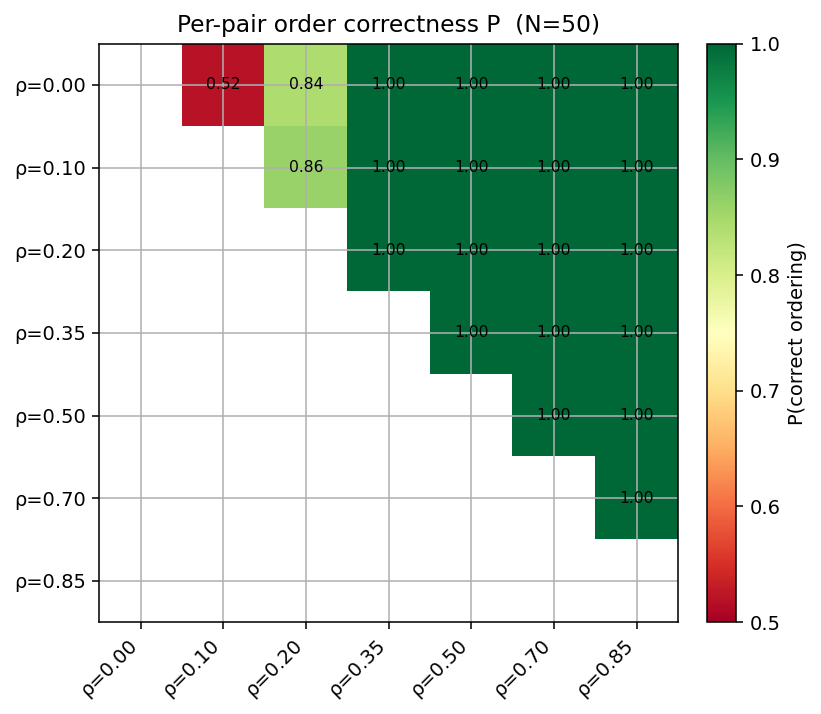


Per-ρ exact-rank probabilities (N=50):


,rho,p_exact_rank
0,0.000000,0.500
1,0.100000,0.460
2,0.200000,0.760
3,0.350000,1.000
4,0.500000,1.000
5,0.700000,1.000
6,0.850000,1.000


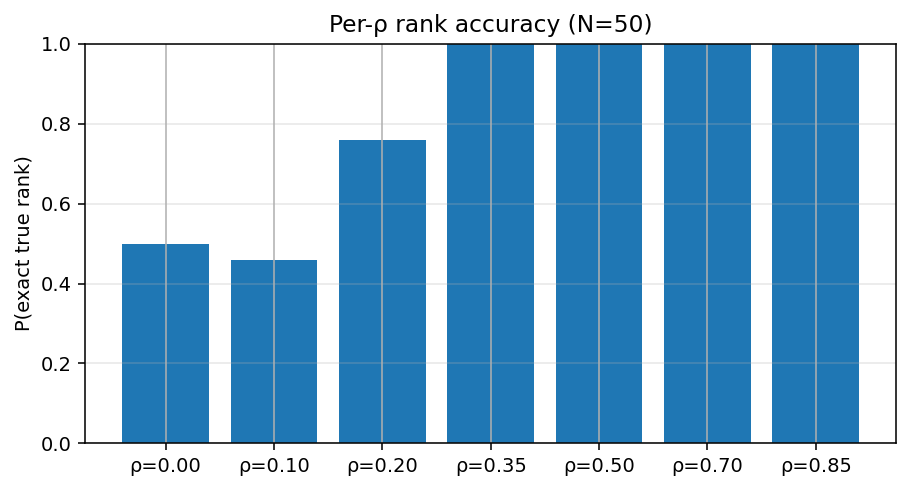


Monotone-invariance: within-(rep,ρ) std across families (N=50)


,rho,std_mean,std_median,std_p95
0,0.000000,0.1243,0.1155,0.2032
1,0.100000,0.1271,0.1239,0.1660
2,0.200000,0.1482,0.1424,0.2036
3,0.350000,0.2124,0.2077,0.3215
4,0.500000,0.2756,0.2731,0.3804
5,0.700000,0.3831,0.3877,0.5154
6,0.850000,0.4350,0.4493,0.7169


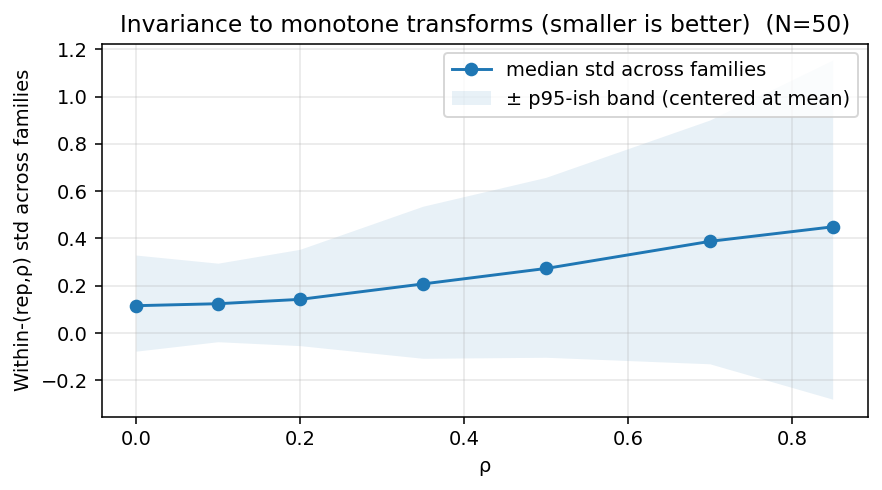


ORDER PROPERTY — OVERALL (N=100)


,N,reps,pairwise_acc_mean,pairwise_acc_median,pairwise_acc_std,pairwise_acc_p05,pairwise_acc_p95
0,100.000,50.000,0.981,1.000,0.025,0.952,1.000



Pairwise correctness probabilities (first 10 rows, N=100):


C:\Users\bseis\AppData\Local\Temp\ipykernel_58068\2925076027.py:117: RuntimeWarning: Mean of empty slice
  M_prob = np.nanmean(M_stack, axis=0)  # probability per (i<j)


,N,rho_i,rho_j,p_correct
0,100,0.000000,0.100000,0.700
1,100,0.000000,0.200000,0.980
2,100,0.000000,0.350000,1.000
3,100,0.000000,0.500000,1.000
4,100,0.000000,0.700000,1.000
5,100,0.000000,0.850000,1.000
6,100,0.100000,0.200000,0.920
7,100,0.100000,0.350000,1.000
8,100,0.100000,0.500000,1.000
9,100,0.100000,0.700000,1.000


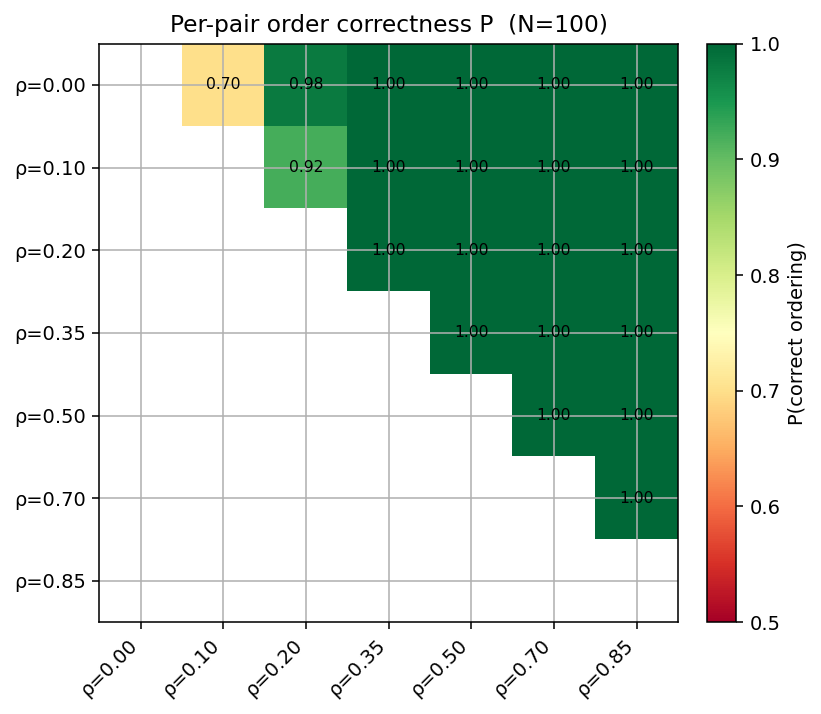


Per-ρ exact-rank probabilities (N=100):


,rho,p_exact_rank
0,0.000000,0.700
1,0.100000,0.620
2,0.200000,0.900
3,0.350000,1.000
4,0.500000,1.000
5,0.700000,1.000
6,0.850000,1.000


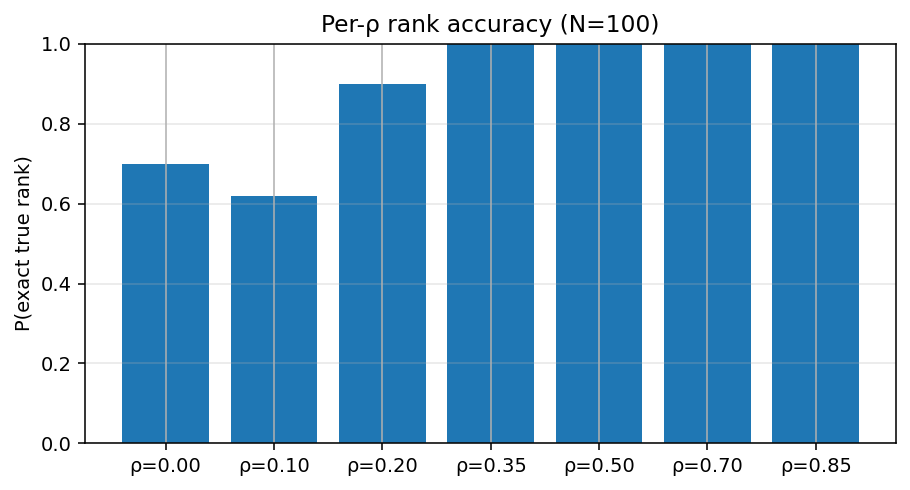


Monotone-invariance: within-(rep,ρ) std across families (N=100)


,rho,std_mean,std_median,std_p95
0,0.000000,0.0929,0.0904,0.1454
1,0.100000,0.1022,0.1000,0.1387
2,0.200000,0.1217,0.1222,0.1637
3,0.350000,0.1709,0.1755,0.2265
4,0.500000,0.2446,0.2422,0.3258
5,0.700000,0.3536,0.3520,0.4503
6,0.850000,0.3631,0.3763,0.5390


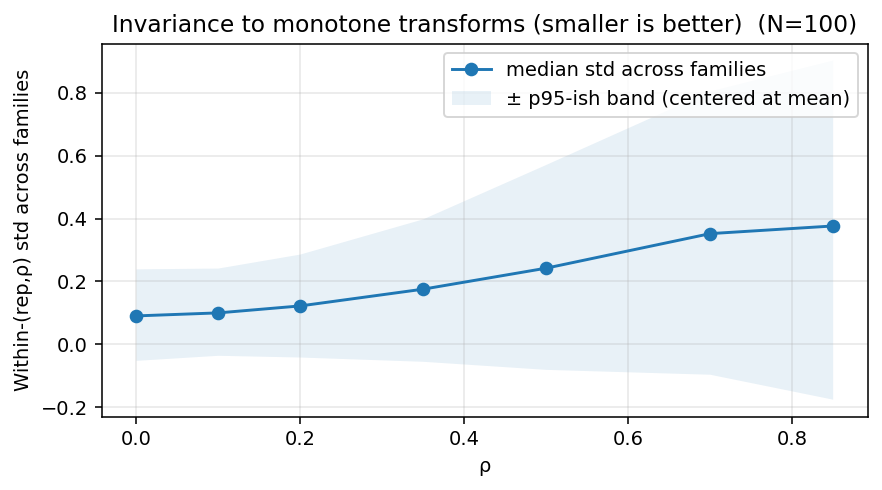


ORDER PROPERTY — OVERALL (N=200)


,N,reps,pairwise_acc_mean,pairwise_acc_median,pairwise_acc_std,pairwise_acc_p05,pairwise_acc_p95
0,200.000,50.000,0.987,1.000,0.021,0.952,1.000



Pairwise correctness probabilities (first 10 rows, N=200):


C:\Users\bseis\AppData\Local\Temp\ipykernel_58068\2925076027.py:117: RuntimeWarning: Mean of empty slice
  M_prob = np.nanmean(M_stack, axis=0)  # probability per (i<j)


,N,rho_i,rho_j,p_correct
0,200,0.000000,0.100000,0.740
1,200,0.000000,0.200000,1.000
2,200,0.000000,0.350000,1.000
3,200,0.000000,0.500000,1.000
4,200,0.000000,0.700000,1.000
5,200,0.000000,0.850000,1.000
6,200,0.100000,0.200000,0.980
7,200,0.100000,0.350000,1.000
8,200,0.100000,0.500000,1.000
9,200,0.100000,0.700000,1.000


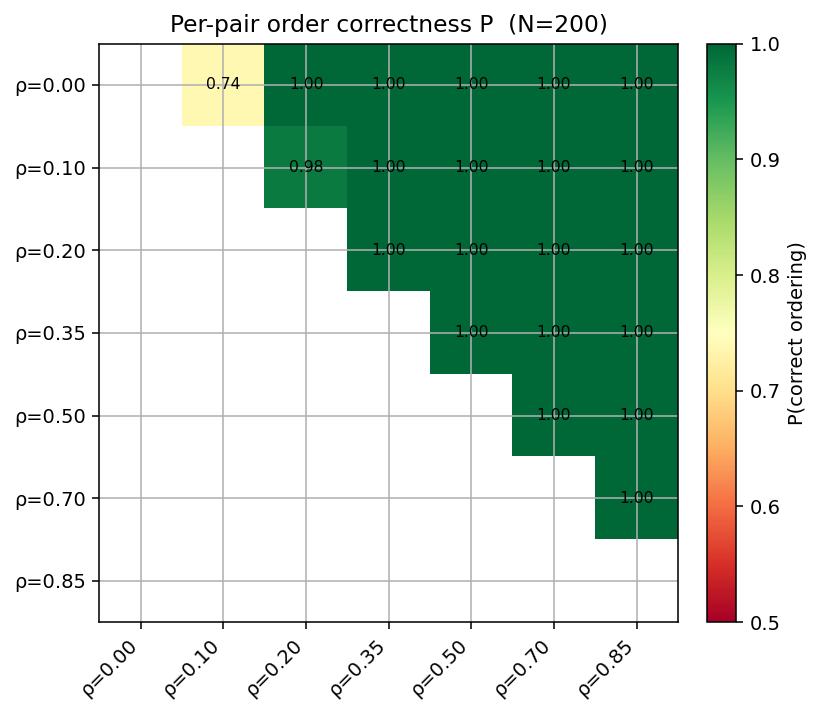


Per-ρ exact-rank probabilities (N=200):


,rho,p_exact_rank
0,0.000000,0.740
1,0.100000,0.720
2,0.200000,0.980
3,0.350000,1.000
4,0.500000,1.000
5,0.700000,1.000
6,0.850000,1.000


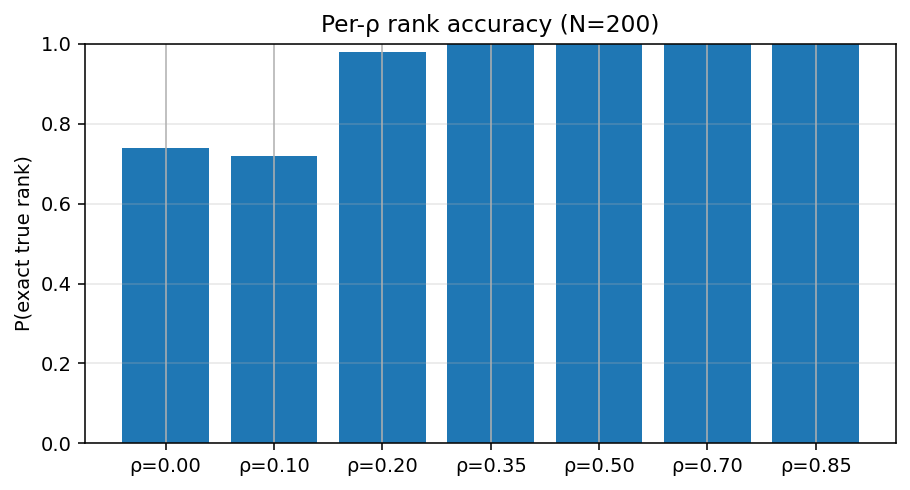


Monotone-invariance: within-(rep,ρ) std across families (N=200)


,rho,std_mean,std_median,std_p95
0,0.000000,0.0732,0.0738,0.1167
1,0.100000,0.0801,0.0788,0.1046
2,0.200000,0.0968,0.0960,0.1308
3,0.350000,0.1406,0.1404,0.1790
4,0.500000,0.2022,0.1981,0.2704
5,0.700000,0.2810,0.2751,0.3706
6,0.850000,0.2669,0.2766,0.4051


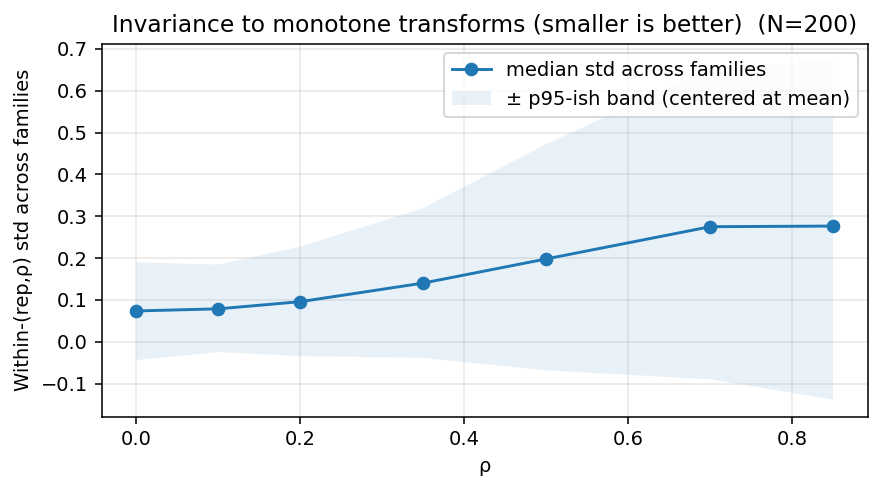

In [41]:
# Run Gaussian + t + Clayton (truth = Kendall’s tau)
_ = run_and_report_copulas(
    N_list=(50,100,200),
    k_list=(4,),
    copulas=(
        {"name":"gaussian", "taus": (0.0,0.1,0.2,0.35,0.5,0.7,0.85)},
        {"name":"t",        "taus": (0.0,0.1,0.2,0.35,0.5,0.7), "nu": 8},
        {"name":"clayton",  "taus": (0.1,0.2,0.35,0.5,0.7)},
    ),
    reps_per_condition=50,
    use_truth="tau",
)


##############################################################################
# ORDER PROPERTY across copulas  |  k = 4  |  truth = tau
##############################################################################

ORDER PROPERTY — OVERALL (N=50)


,N,reps,pairwise_acc_mean,pairwise_acc_median,pairwise_acc_std,pairwise_acc_p05,pairwise_acc_p95
0,50.000,50.000,0.980,1.000,0.045,0.900,1.000



Pairwise correctness probabilities (first 10 rows, N=50):


C:\Users\bseis\AppData\Local\Temp\ipykernel_58068\2925076027.py:117: RuntimeWarning: Mean of empty slice
  M_prob = np.nanmean(M_stack, axis=0)  # probability per (i<j)


,N,rho_i,rho_j,p_correct
0,50,0.100000,0.200000,0.860
1,50,0.100000,0.350000,0.980
2,50,0.100000,0.500000,1.000
3,50,0.100000,0.700000,1.000
4,50,0.200000,0.350000,0.980
5,50,0.200000,0.500000,1.000
6,50,0.200000,0.700000,1.000
7,50,0.350000,0.500000,0.980
8,50,0.350000,0.700000,1.000
9,50,0.500000,0.700000,1.000


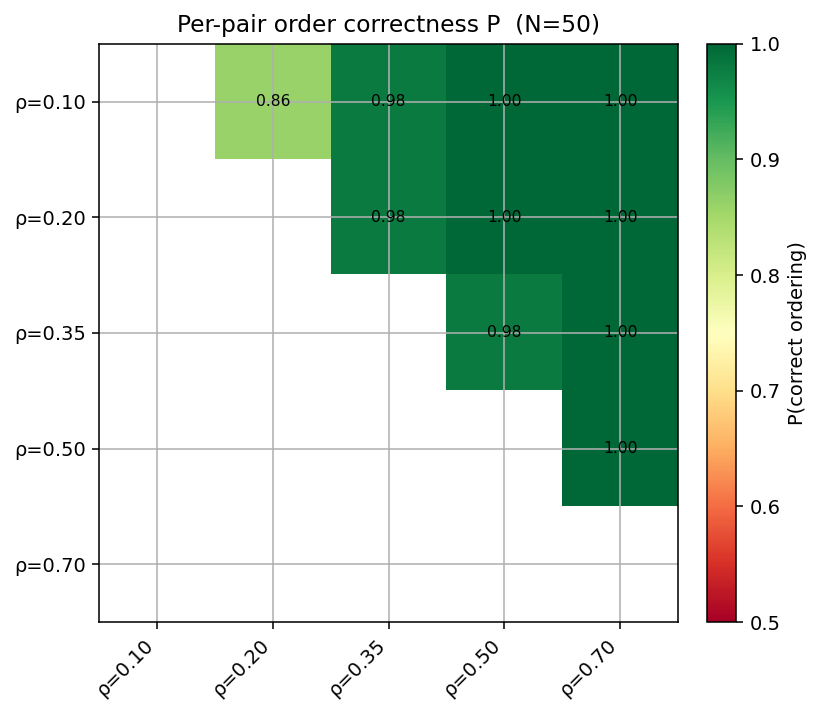


Per-ρ exact-rank probabilities (N=50):


,rho,p_exact_rank
0,0.100000,0.840
1,0.200000,0.840
2,0.350000,0.960
3,0.500000,0.980
4,0.700000,1.000


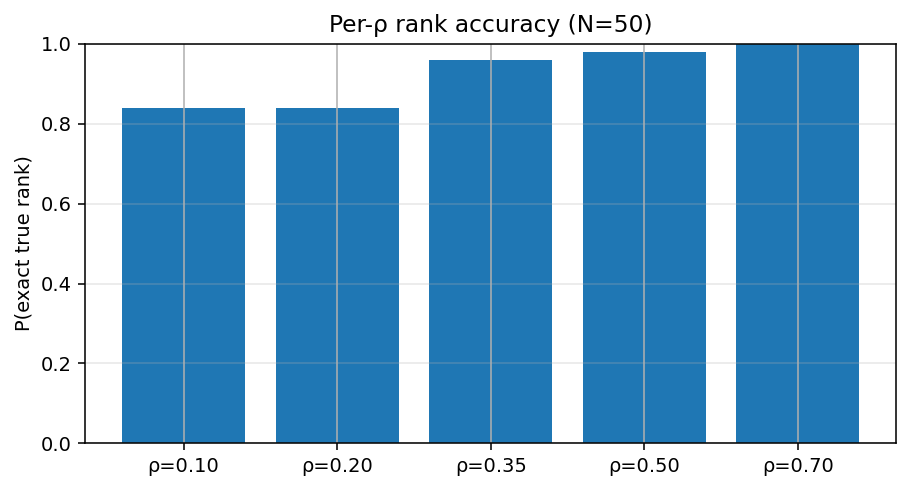


Monotone-invariance: within-(rep,ρ) std across families (N=50)


,rho,std_mean,std_median,std_p95
0,0.100000,0.1183,0.1118,0.2242
1,0.200000,0.1527,0.1501,0.2533
2,0.350000,0.2101,0.2134,0.3599
3,0.500000,0.3164,0.3199,0.5591
4,0.700000,0.3902,0.3951,0.6410


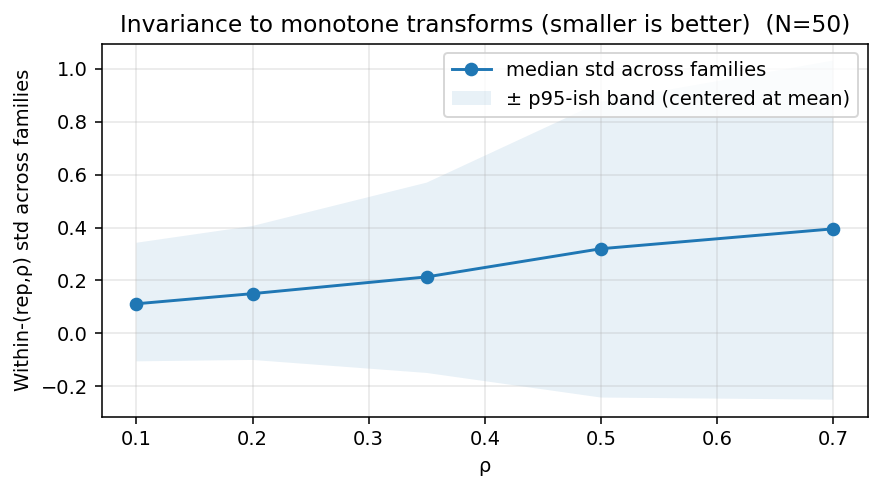


ORDER PROPERTY — OVERALL (N=100)


,N,reps,pairwise_acc_mean,pairwise_acc_median,pairwise_acc_std,pairwise_acc_p05,pairwise_acc_p95
0,100.000,50.000,0.980,1.000,0.040,0.900,1.000



Pairwise correctness probabilities (first 10 rows, N=100):


C:\Users\bseis\AppData\Local\Temp\ipykernel_58068\2925076027.py:117: RuntimeWarning: Mean of empty slice
  M_prob = np.nanmean(M_stack, axis=0)  # probability per (i<j)


,N,rho_i,rho_j,p_correct
0,100,0.100000,0.200000,0.800
1,100,0.100000,0.350000,1.000
2,100,0.100000,0.500000,1.000
3,100,0.100000,0.700000,1.000
4,100,0.200000,0.350000,1.000
5,100,0.200000,0.500000,1.000
6,100,0.200000,0.700000,1.000
7,100,0.350000,0.500000,1.000
8,100,0.350000,0.700000,1.000
9,100,0.500000,0.700000,1.000


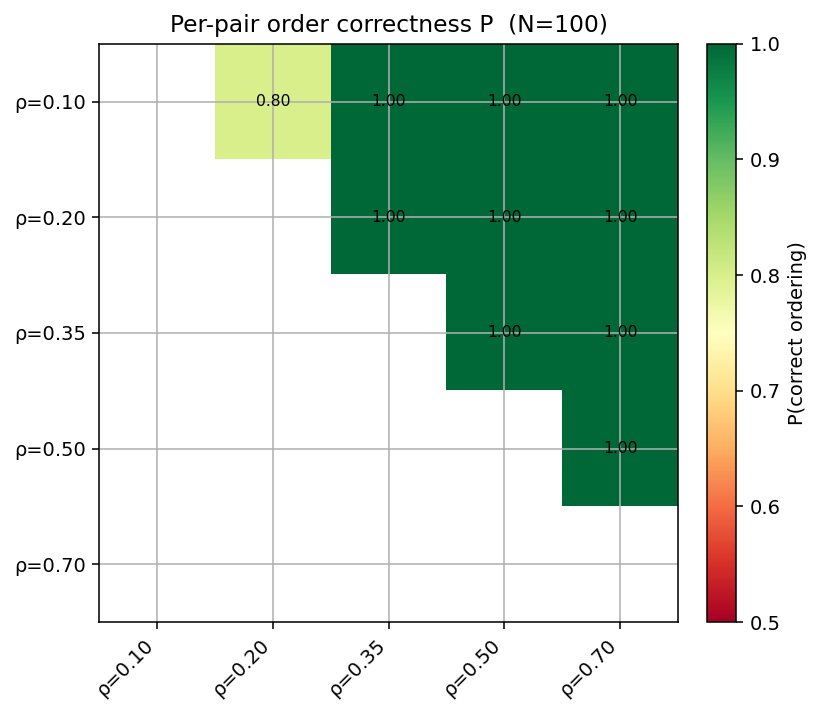


Per-ρ exact-rank probabilities (N=100):


,rho,p_exact_rank
0,0.100000,0.800
1,0.200000,0.800
2,0.350000,1.000
3,0.500000,1.000
4,0.700000,1.000


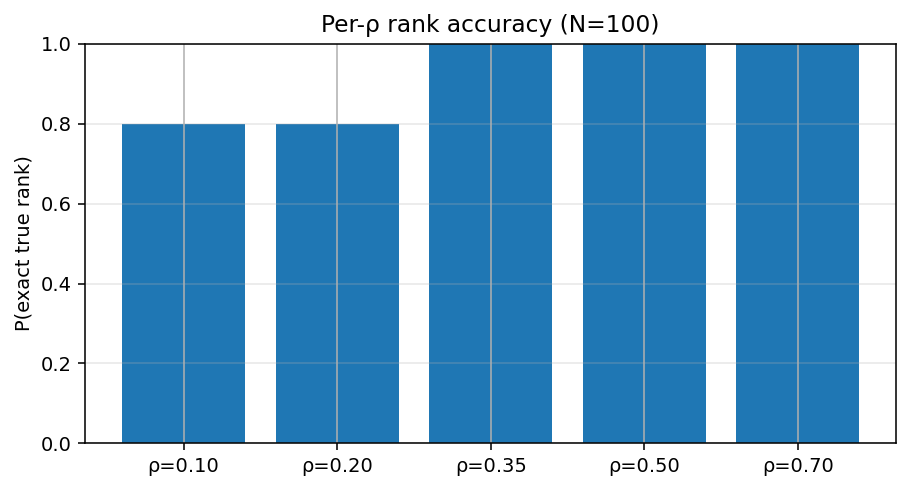


Monotone-invariance: within-(rep,ρ) std across families (N=100)


,rho,std_mean,std_median,std_p95
0,0.100000,0.1056,0.0959,0.1947
1,0.200000,0.1235,0.1111,0.2378
2,0.350000,0.1615,0.1436,0.2810
3,0.500000,0.2515,0.2424,0.4255
4,0.700000,0.3038,0.2858,0.4654


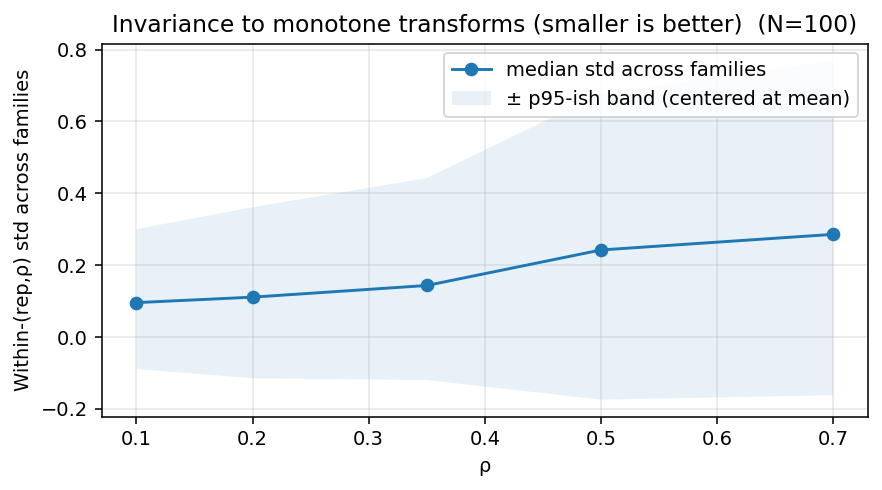


ORDER PROPERTY — OVERALL (N=200)


,N,reps,pairwise_acc_mean,pairwise_acc_median,pairwise_acc_std,pairwise_acc_p05,pairwise_acc_p95
0,200.000,50.000,0.990,1.000,0.030,0.900,1.000



Pairwise correctness probabilities (first 10 rows, N=200):


C:\Users\bseis\AppData\Local\Temp\ipykernel_58068\2925076027.py:117: RuntimeWarning: Mean of empty slice
  M_prob = np.nanmean(M_stack, axis=0)  # probability per (i<j)


,N,rho_i,rho_j,p_correct
0,200,0.100000,0.200000,0.900
1,200,0.100000,0.350000,1.000
2,200,0.100000,0.500000,1.000
3,200,0.100000,0.700000,1.000
4,200,0.200000,0.350000,1.000
5,200,0.200000,0.500000,1.000
6,200,0.200000,0.700000,1.000
7,200,0.350000,0.500000,1.000
8,200,0.350000,0.700000,1.000
9,200,0.500000,0.700000,1.000


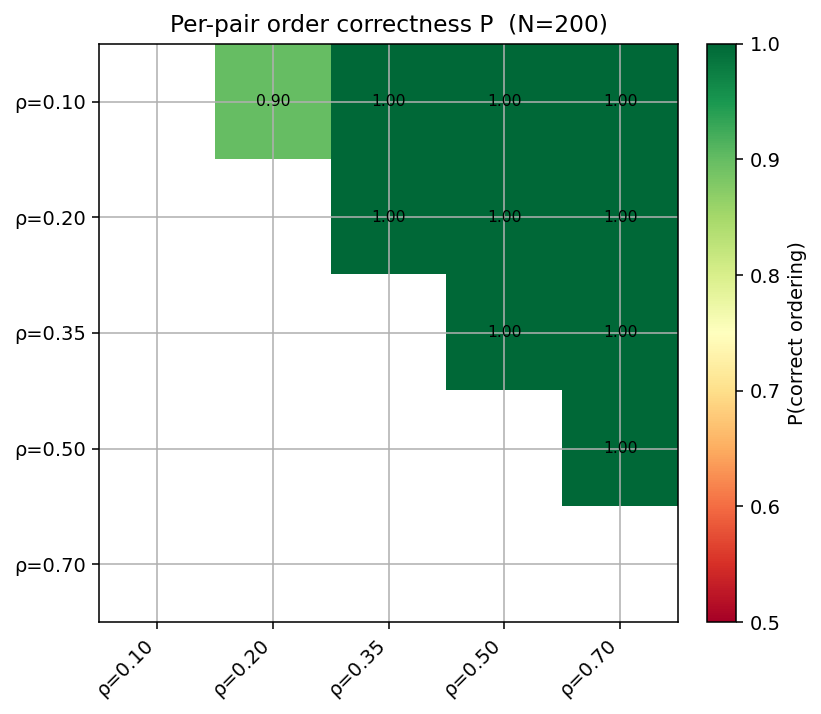


Per-ρ exact-rank probabilities (N=200):


,rho,p_exact_rank
0,0.100000,0.900
1,0.200000,0.900
2,0.350000,1.000
3,0.500000,1.000
4,0.700000,1.000


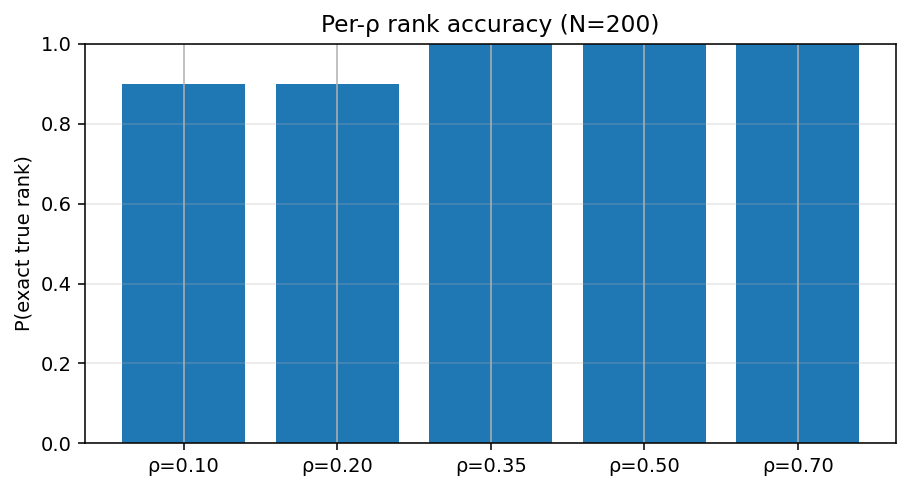


Monotone-invariance: within-(rep,ρ) std across families (N=200)


,rho,std_mean,std_median,std_p95
0,0.100000,0.0781,0.0701,0.1322
1,0.200000,0.1023,0.0923,0.1695
2,0.350000,0.1280,0.1243,0.2216
3,0.500000,0.1647,0.1632,0.2617
4,0.700000,0.2351,0.2187,0.3766


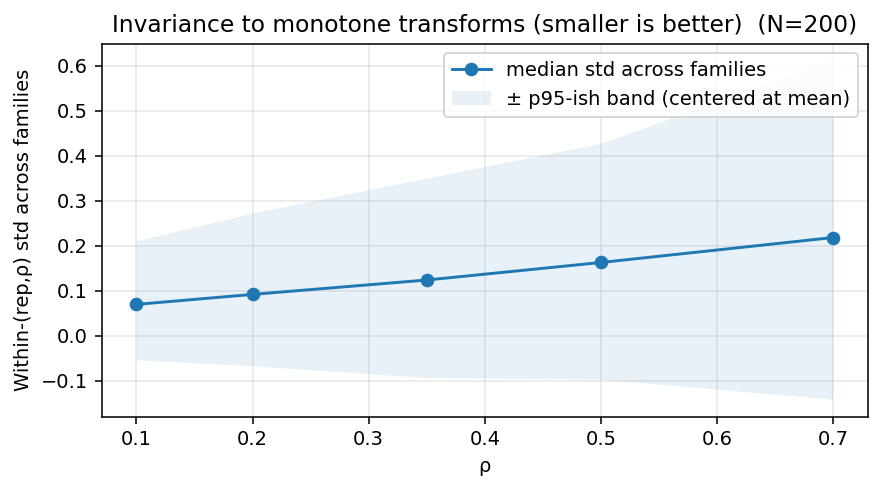

In [45]:
# Clayton supports only positive dependence (tau in (0,1))
_ = run_and_report_copulas(
    N_list=(50, 100, 200),
    k_list=(4,),
    copulas=(
        {"name": "clayton", "taus": (0.1, 0.2, 0.35, 0.5, 0.7)},
    ),
    reps_per_condition=50,
    use_truth="tau",
)